<a href="https://colab.research.google.com/github/Mounika0577/newrepository/blob/main/music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [45]:
# lets import libraries that we will be usings
# we already have imported pandas and numpy

import matplotlib.pyplot as plt
import scipy
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import pickle # model pickling for future use

In [46]:
# Loading dataset
# we have 2 CSVs here, one containing features for 30 sec audio file, mean & variance for diff features we have, then
# and one for 3 sec audio files. I will be using 3 sec audio
dataf = pd.read_csv("/content/features_3_sec.csv")
dataf.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [47]:
# removing filename column
dataf = dataf.drop(labels='filename',axis=1)

In [48]:
# looking into what i have 
sample_audio = "/content/pop.00003.wav"
sample, sample_rate = librosa.load(sample_audio)


ipd.Audio(sample, rate=sample_rate)

In [49]:
sample, sample_rate = librosa.load(sample_audio, sr=16000)
print(len(sample),sample_rate)

480003 16000


<class 'numpy.ndarray'> 16000


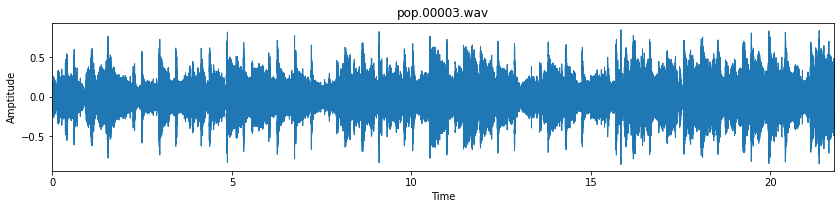

In [50]:
print(type(sample),sample_rate)
sample, sample_rate = librosa.load(sample_audio, sr=16000)

# plotting raw wave Files, here it is for Pop genre
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
ax1.set_title("pop.00003.wav")
ax1.set_xlabel('time')
ax1.set_ylabel('Amptitude')
librosa.display.waveplot(sample)
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


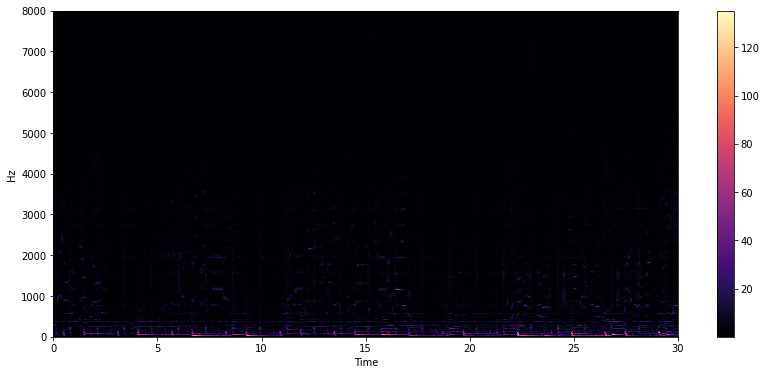

In [51]:
# Spectrogram, we have this in images folder
# way of representing signal loudness at diff freq
# also known as Sonographs
# when data is 3D then waterfall

stft = librosa.stft(sample)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sample_rate,x_axis='time',y_axis='hz')
plt.colorbar()

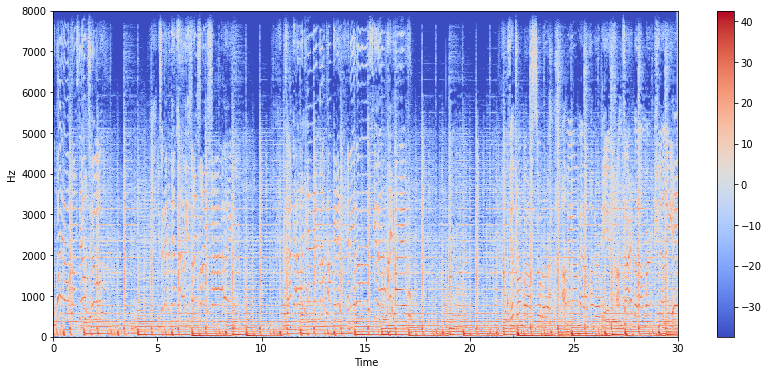

In [52]:
stft = librosa.stft(sample)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sample_rate,x_axis='time',y_axis='hz')
plt.colorbar()

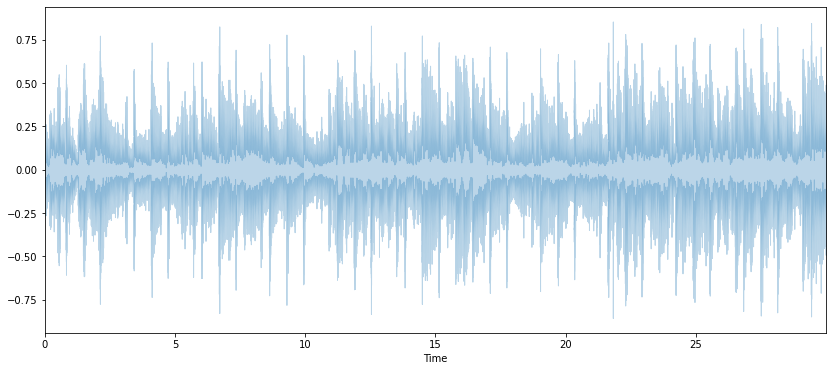

In [53]:
# Rolloff - feq below which a specified percentage of the total spectral lies / 85%
from sklearn.preprocessing import normalize

spectral_rolloff = librosa.feature.spectral_rolloff(sample+0.01,sr=sample_rate)[0]
plt.figure(figsize=(14,6))
librosa.display.waveplot(sample,sr=sample_rate,alpha=0.3)

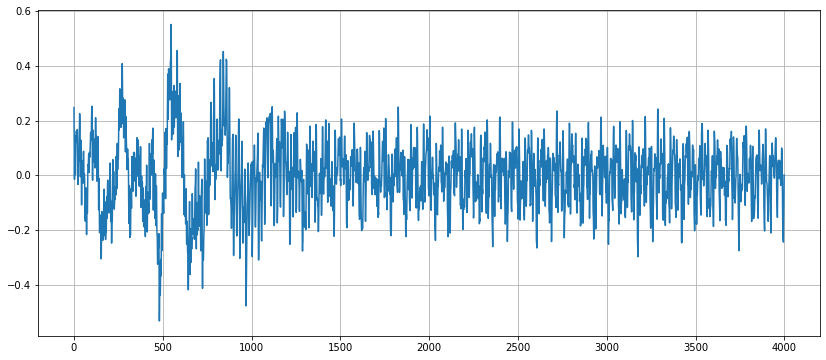

In [54]:
# Zero crossing 
plt.figure(figsize=(14,6))
plt.plot(sample[8000:12000])
plt.grid()

In [55]:
#count
zero_cross = librosa.zero_crossings(sample[8000:12000],pad=False)
print("Count {}".format(sum(zero_cross)))

Count 498


In [56]:
class_list = dataf.iloc[:,-1] 
convert = LabelEncoder()

In [57]:
y = convert.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [58]:
dataf.iloc[:,:-1]

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,1642

In [59]:
# scaling features
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(dataf.iloc[:,:-1],dtype=float))

In [60]:
# dividing into training and test Data
X_train,x_test, Y_train, y_test = train_test_split(X,y,test_size=0.2)

In [61]:
print(len(Y_train),len(y_test))

7992 1998


In [62]:
# Using CNN algorithm
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
# building model

model = Sequential()

model.add(Dense(512,input_shape=(X_train.shape[1],),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               30208     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [64]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001)
modelcheck = ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
history = model.fit(X_train,Y_train, validation_data=(x_test,y_test), epochs=600, callbacks=[earlystop,modelcheck], batch_size=128)

Epoch 1/600
63/63 [==============================] - 1s 14ms/step - loss: 1.5960 - accuracy: 0.4258 - val_loss: 1.0473 - val_accuracy: 0.6336

Epoch 00001: val_accuracy improved from -inf to 0.63363, saving model to best_model.hdf5
Epoch 2/600
63/63 [==============================] - 1s 10ms/step - loss: 1.0606 - accuracy: 0.6338 - val_loss: 0.7956 - val_accuracy: 0.7332

Epoch 00002: val_accuracy improved from 0.63363 to 0.73323, saving model to best_model.hdf5
Epoch 3/600
63/63 [==============================] - 1s 11ms/step - loss: 0.8737 - accuracy: 0.7043 - val_loss: 0.7215 - val_accuracy: 0.7538

Epoch 00003: val_accuracy improved from 0.73323 to 0.75375, saving model to best_model.hdf5
Epoch 4/600
63/63 [==============================] - 1s 10ms/step - loss: 0.7520 - accuracy: 0.7514 - val_loss: 0.6606 - val_accuracy: 0.7858

Epoch 00004: val_accuracy improved from 0.75375 to 0.78579, saving model to best_model.hdf5
Epoch 5/600
63/63 [==============================] - 1s 10ms/st

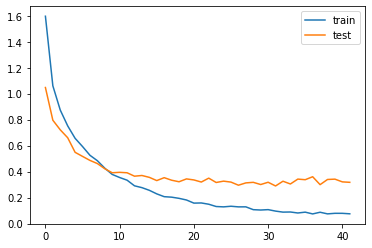

In [65]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [66]:
#from keras.models import load_model
#Model = load_model("./best_model.hdf5")
test_loss, test_accuracy = model.evaluate(x_test,y_test,batch_size=128)
print("Test loss : ",test_loss)
print("\nBest test accuracy : ",test_accuracy*100)

16/16 [==============================] - 0s 3ms/step - loss: 0.3174 - accuracy: 0.9204
Test loss :  0.3173644542694092

Best test accuracy :  92.04204082489014
